# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


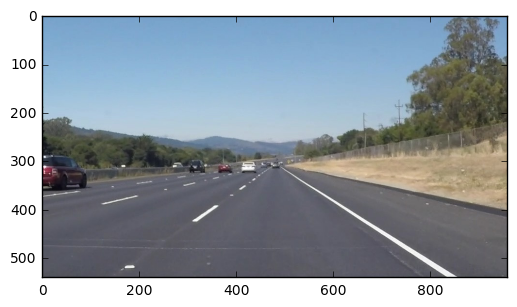

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [5]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=6):
    
    #Define different collections for right/left lane line  
    positive_slope=[]
    positive_x=[]
    positive_y=[]
    
    negative_slope=[]
    negative_x=[]
    negative_y=[]
    
    #Define y min/max - bottom left to bottom right corner of image
    y_min=320
    y_max=img.shape[0]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            #identify global minimum
            if y1 < y_min:
                y_min = y1
                
            #simple gradient formula
            slope = (y2-y1)/(x2-x1)
            
            if slope < 0: #left line, negative slope
                negative_slope.append(slope)
                negative_x.append(x1)
                negative_x.append(x2)
                negative_y.append(y1)
                negative_y.append(y2)
                               
            elif slope > 0: #right line, positive slope
                positive_slope.append(slope)
                positive_x.append(x1)
                positive_x.append(x2)
                positive_y.append(y1)
                positive_y.append(y2)
                
    #Averaging the right gradient ie: m
    avg_pos_slope= sum(positive_slope)/float(len(positive_slope))
    
    #Averaging the x and y values ie: x and y
    avg_pos_x=sum(positive_x)/float(len(positive_x))
    avg_pos_y=sum(positive_y)/float(len(positive_y))
    
    #Calculate intercept for averaged right lane coordinates ie: c = y - mx
    pos_intercept= avg_pos_y-(avg_pos_slope*avg_pos_x)
    
    #Find maximum x1,x2, ie: x1 = (y-c)/m
    x1_pos=(y_min-pos_intercept)/avg_pos_slope
    x2_pos=(y_max-pos_intercept)/avg_pos_slope
    
    #Draw right line
    cv2.line(img, (int(x1_pos), y_min), (int(x2_pos), y_max), color, thickness)

    
    #Averaging the left gradient ie: m
    avg_neg_slope= sum(negative_slope)/float(len(negative_slope))
    
    #Averaging the x and y values  ie: x and y
    avg_neg_x=sum(negative_x)/float(len(negative_x))
    avg_neg_y=sum(negative_y)/float(len(negative_y))
    
    #Calculate intercept for averaged left lane coordinates ie: c = y - mx
    neg_intercept= avg_neg_y-(avg_neg_slope*avg_neg_x)
    
    #Find maximum x1,x2, ie: x1 = (y-c)/m
    x1_neg=(y_min-neg_intercept)/avg_neg_slope
    x2_neg=(y_max-neg_intercept)/avg_neg_slope
    
    #Draw left line
    cv2.line(img, (int(x1_neg), y_min), (int(x2_neg), y_max), color, thickness)
    
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

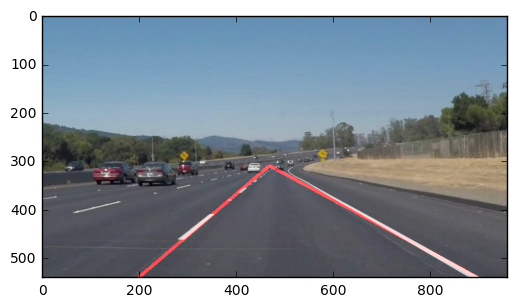

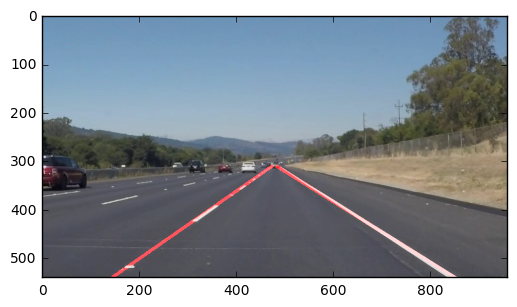

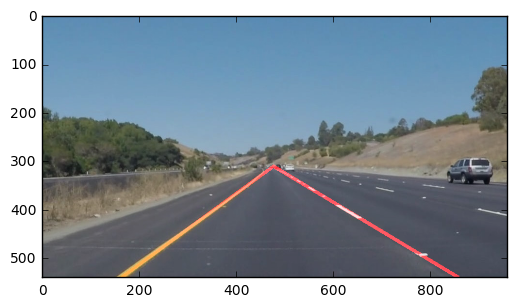

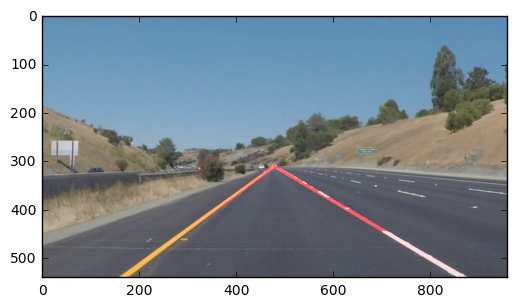

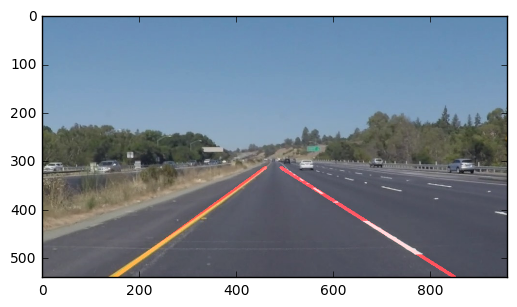

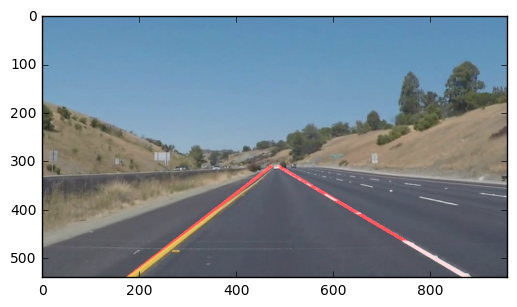

In [6]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#set a path to read list of images
PATH= "test_images/"
images =os.listdir(PATH)

for i in range(len(images)): 
    
    img = (mpimg.imread(PATH+images[i])) #original image

    # Read in and grayscale the image
    image = (mpimg.imread(PATH+images[i])*255)
    gray = grayscale(image)

    # Define a kernel size and apply gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray,kernel_size)

    # Define parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 310),(490, 310), (imshape[1],imshape[0])]], dtype=np.int32)

    # Define region of interest
    masked_edges = region_of_interest(edges, vertices)

 
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 5 #1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 80 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 50   # maximum gap in pixels between connectable line segments
    line_image = np.copy(masked_edges)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                               min_line_length, max_line_gap)

    draw_lines(line_image, lines)   

    # Create a "color" binary image to combine with line image
    additional_channels = np.dstack((np.zeros_like(line_image),)*(imshape[2]-1))
    multi_channel_line_image = np.dstack((line_image, additional_channels))

    # Display the image and show region and color selections
    lines_edges = weighted_img( multi_channel_line_image, img, α=0.9, β=1., λ=0.)

    # Display the image
    plt.imshow(lines_edges)  # this should be the final image with the annotated red lines.
    plt.show()

    mpimg.imsave('test_images/'+str([i])+'test.png', lines_edges)


run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
# NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    gray = grayscale(image)

    # Define a kernel size and apply gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray,kernel_size)

    # Define parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Define the Hough transform parameters
    rho = 5 #1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 80 #200# minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 50  # maximum gap in pixels between connectable line segments
        
    # Defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 310),(490, 310), (imshape[1],imshape[0])]], dtype=np.int32)

    # Define region of interest
    masked_edges = region_of_interest(edges, vertices)
    line_image = np.copy(masked_edges)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    draw_lines(line_image, lines)   

    # Create a "color" binary image to combine with line image
    additional_channels = np.dstack((np.zeros_like(line_image),)*(imshape[2]-1))
    multi_channel_line_image = np.dstack((line_image, additional_channels))

    # Display the image and show region and color selections
    result = weighted_img( multi_channel_line_image, image, α=0.9, β=1., λ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:04<00:00, 45.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 5.15 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:14<00:00, 46.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 15.3 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Thoughts - Gary Lai

I have so much to say in this topic, that I could write a thesis on lane markings alone! There are so many limitations when just using cameras as a lane assist or basic 'Autopilot' for self-driving cars. A fatal Tesla car crash in May (tragic death of Joshua Brown, Florida) demonstrated these limitations since the camera can only 'look' and scan a very small quadrilateral section at the bottom-front, even if the algorithm and code was perfect it does not take into consideration of objects above or outside the region. 
For example, if a semi-truck was to be parked sideways onto the road, (the trailer is clearly out of the vision of the car cameras) the car would drive through the truck at highway speeds since it cannot detect any obstacles at the floor or road. 
Although I applaud Tesla for pushing through electric vehicles and self driving cars so quickly, I personally feel that the inclusion of Lidar systems would be much more safer, as Lidar can detect the physcial objects in its surroundings, similar to a bat's sonar.

Tha advantages of a basic camera system however, it is dirt cheap. Cameras can be bought off shelf for dollars and cents, whereas Lidar systems can cost more than the car itself. However I really like how this technology is advancing very rapidly as we speak, and Velodyne revealed some cool new Lidar systems which is around the same size and shape of a giant hockey puck. 

In order to make the algrithm more robust, the draw lines function could be tweaked so that the lane line could be calculated over small pieces so that the car can adapt to steep turning angles by calculating the gradients. (What happens if there is a sharp U-turn or hairpin road?) 
I tried putting in my algorithm in the 'challenge' video, and it is clear that under bright or extreme contrast scenarios, the car would go berserk (my program crashed) and detect lines everywhere,(due to tree branches, concrete etc) and sometimes it wont even detect the yellow lane markings under intense light (no contrasting area means the canny method wont work)

So for the challenge video, I reverted and used the basic draw_lines function provided, to see what was going on. Altough I couldnt send the attached video, I could see the hough lines/canny detection was all over the place. This is why the algorithm using 'slope' do plot lines crashed.  


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


 20%|████████▎                                | 51/251 [00:01<00:08, 24.59it/s]

ValueError: cannot convert float NaN to integer

 20%|████████▎                                | 51/251 [00:20<01:18,  2.55it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))